# Baseline model - simple MLP


Imports:

In [105]:
import copy
import pandas as pd
import numpy as np
import pathlib
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

read data:

In [106]:
df_hard = pd.read_excel('all_data_long.xlsx')

In [107]:
df_hard['Fictive ID'].nunique()

36240

In [254]:
all_df = copy.deepcopy(df_hard)
all_df.columns = all_df.columns.str.replace("'", "")
features_to_start = ['year', 'מין', 'סוג פיקוח', ' פסיכומטרי רב תחומי', 'פסיכומטרי כמותי', 'פסיכומטרי מילולי',
               'שפת פסיכומטרי', 'בגרות', 'ציון מכינה', 'ניקוד רל"ק', 'שנת לידה', 'פקולטה', 'חוג', 'מסלול', 'משקולל קיים', 'נשר חיצונית']
df = all_df[features_to_start]

feature_names_to_replace = {"מין": "gender", 'סוג פיקוח': 'supervision_type',
                        ' פסיכומטרי רב תחומי': 'psico_rav', 'פסיכומטרי כמותי':'psico_camul',
                        'פסיכומטרי מילולי':'psico_verb', 'שפת פסיכומטרי': 'psico_leng',
                        'בגרות':'bag', 'ציון מכינה':'preparatory_score', 'ניקוד רל"ק':'ralak_score',
                        'שנת לידה':'birth_year', 'פקולטה':'faculty',
                        'חוג':'hug', 'מסלול':'study_track', 'משקולל קיים':'weighted_score', 'נשר חיצונית':'dropouts'}

df = df.rename(columns=feature_names_to_replace)

features_to_start_id = features_to_start.copy()
features_to_start_id.append('Fictive ID')
df_id = all_df[features_to_start_id]
df_id = df_id.rename(columns=feature_names_to_replace)



split to train and test:

In [109]:
def split_train_test(df):
    X = df.drop('dropouts', axis=1)
    Y = df['dropouts'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)
    
    # Reset indices for compatibility
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True)
    y_test = pd.Series(y_test).reset_index(drop=True)
    return X_train, X_test, y_train, y_test

build base model:

In [306]:
class DropuotsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features.iloc[idx].values, dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [307]:
class BaseModelNN(nn.Module):
    def __init__(self, input_dim):
        super(BaseModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 12)
        self.fc2 = nn.Linear(12, 6)
        self.output = nn.Linear(6, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x

training loop:

In [235]:
numeric_features = df.select_dtypes(include=['number']).columns
numeric_features = np.delete(numeric_features, np.where(numeric_features == 'hug')[0][0])
numeric_df = df[numeric_features].drop_duplicates()
X_train, X_test, y_train, y_test = split_train_test(numeric_df)

In [308]:
# Create DataLoader
batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

initialize model and optimizer:

In [309]:
model = BaseModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [310]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    model.to(device)  # Move model to the specified device (CPU or GPU)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for batch in train_loader:
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)  # Ensure labels are shaped as (batch_size, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")

In [311]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.2165
Epoch [2/10], Loss: 0.1969
Epoch [3/10], Loss: 0.1947
Epoch [4/10], Loss: 0.1938
Epoch [5/10], Loss: 0.1930
Epoch [6/10], Loss: 0.1924
Epoch [7/10], Loss: 0.1920
Epoch [8/10], Loss: 0.1916
Epoch [9/10], Loss: 0.1910
Epoch [10/10], Loss: 0.1907
Training complete.


evaluation:

In [324]:
def evaluate_model(model, data_loader, criterion, device, threshold=0.05):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions and probabilities
            probabilities = outputs.squeeze().cpu().numpy()  # Convert to numpy array
            predictions = (probabilities >= threshold).astype(int)  # Threshold for binary classification
            labels = labels.cpu().numpy()  # Convert labels to numpy

            # Store results
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            all_probs.extend(probabilities)

    # Compute average loss
    avg_loss = total_loss / len(data_loader)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"Evaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return {'loss': avg_loss,
            'accuracy_score': accuracy,
            'precision_score': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'lables': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probs}


In [325]:
test_eval_results = evaluate_model(model, test_loader, criterion, device)

Evaluation Results:
Loss: 0.1968
Accuracy: 0.5341
Precision: 0.0781
Recall: 0.7180
F1 Score: 0.1408
ROC AUC: 0.6831


In [321]:
max(test_eval_results['probabilities'])
y_train.mean()

np.float64(0.052258717453307575)

this model practically predicts all students will drop. this is obviousley not good.

# Enhancements: 
change stochastic gradient decent fetchers to dill with the unbalances df

learning rate from 0.01 to 0.001, 

set weight decay 0.0005

change the threshold for binary classification from 0.5 to mean(y_train)

In [154]:
batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = BaseModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

threshold = y_train.mean()
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=0.1)

Epoch [1/10], Loss: 5.4091
Epoch [2/10], Loss: 5.4083
Epoch [3/10], Loss: 5.4087
Epoch [4/10], Loss: 5.4074
Epoch [5/10], Loss: 5.4068
Epoch [6/10], Loss: 5.4058
Epoch [7/10], Loss: 5.4039
Epoch [8/10], Loss: 5.4032
Epoch [9/10], Loss: 5.4035
Epoch [10/10], Loss: 5.4009
Training complete.
Evaluation Results:
Loss: 5.6450
Accuracy: 0.9434
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5072


C:\Users\noasc\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [155]:
set(test_eval_results['probabilities'])

{np.float32(0.0),
 np.float32(2.974306e-39),
 np.float32(3.132519e-39),
 np.float32(3.161788e-39),
 np.float32(3.167728e-39),
 np.float32(3.194935e-39),
 np.float32(3.226166e-39),
 np.float32(3.231191e-39),
 np.float32(3.241388e-39),
 np.float32(3.380606e-39),
 np.float32(3.464474e-39),
 np.float32(3.540872e-39),
 np.float32(3.661363e-39),
 np.float32(3.749334e-39),
 np.float32(3.775859e-39),
 np.float32(3.816406e-39),
 np.float32(4.235348e-39),
 np.float32(4.240457e-39),
 np.float32(4.272801e-39),
 np.float32(4.506441e-39),
 np.float32(4.56332e-39),
 np.float32(4.576464e-39),
 np.float32(4.685672e-39),
 np.float32(4.755575e-39),
 np.float32(4.778708e-39),
 np.float32(4.979581e-39),
 np.float32(5.004261e-39),
 np.float32(5.137768e-39),
 np.float32(5.218e-39),
 np.float32(5.336649e-39),
 np.float32(5.398155e-39),
 np.float32(5.54251e-39),
 np.float32(5.553939e-39),
 np.float32(5.830789e-39),
 np.float32(5.913716e-39),
 np.float32(5.990505e-39),
 np.float32(6.014868e-39),
 np.float32(6.0

# Enhancements: 
change the model architecture and preprocess data to achive better results

## add layers and neurons:

In [175]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x

batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = MLPModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [176]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.2238
Epoch [2/10], Loss: 0.2145
Epoch [3/10], Loss: 0.2134
Epoch [4/10], Loss: 0.2125
Epoch [5/10], Loss: 0.2126
Epoch [6/10], Loss: 0.2118
Epoch [7/10], Loss: 0.2107
Epoch [8/10], Loss: 0.2123
Epoch [9/10], Loss: 0.2126
Epoch [10/10], Loss: 0.2116
Training complete.


In [177]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=threshold)

Evaluation Results:
Loss: 0.2155
Accuracy: 0.6470
Precision: 0.0739
Recall: 0.4540
F1 Score: 0.1270
ROC AUC: 0.5812


In [179]:
sum(test_eval_results['predictions'])/len(test_eval_results['predictions'])
set(test_eval_results['probabilities'])


{np.float32(0.054300696),
 np.float32(0.07852663),
 np.float32(0.054458503),
 np.float32(0.082828164),
 np.float32(0.06369247),
 np.float32(0.06540201),
 np.float32(0.044562135),
 np.float32(0.054072425),
 np.float32(0.04215524),
 np.float32(0.043823652),
 np.float32(0.06040302),
 np.float32(0.04280698),
 np.float32(0.049119897),
 np.float32(0.072924756),
 np.float32(0.041196488),
 np.float32(0.034595497),
 np.float32(0.055261005),
 np.float32(0.040050853),
 np.float32(0.06216084),
 np.float32(0.0390247),
 np.float32(0.030395854),
 np.float32(0.054882396),
 np.float32(0.039425243),
 np.float32(0.048810225),
 np.float32(0.039868575),
 np.float32(0.054460514),
 np.float32(0.042491067),
 np.float32(0.06033813),
 np.float32(0.035592306),
 np.float32(0.05188023),
 np.float32(0.03606354),
 np.float32(0.047406543),
 np.float32(0.05405984),
 np.float32(0.03294549),
 np.float32(0.069314815),
 np.float32(0.07253705),
 np.float32(0.04626023),
 np.float32(0.053904884),
 np.float32(0.051172968),
 n

It seems like adding layers dosent solve the problem, and the model is still not preforming well.

## preprocess data:
The data preprocess is based on knowledge about this specific usecase and data, as revised by an SME

In [245]:
df.columns

Index(['year', 'gender', 'psico_rav', 'psico_camul', 'psico_verb',
       'psico_leng', 'bag', 'preparatory_score', 'ralak_score', 'birth_year',
       'faculty', 'hug', 'weighted_score', 'dropouts', 'hug_num'],
      dtype='object')

In [300]:
def preprocess_data(data):
    df = data.copy()
    
    # remove samples with 0 bagrut score:
    df = df[df['bag'] != 0]# remove 1252 samples
    
    # df['supervision_type'] = np.where(df['supervision_type'].isna(), 'missing', df['supervision_type'])
    
    # df['ralak'] = np.where(df['ralak_score'] >= 30, 1, 0)
    # df.pop('ralak_score')
    
    # learned in preparatory at huji:
    df['preparatory'] = np.where(df['preparatory_score'] > 0, 1, 0)
    # df.pop('preparatory_score')
    
    # create age feature:
    df['age'] = df['year'] - df['birth_year']
    # df.pop('birth_year')
    # df.pop('חוג')
    # df.pop('פקולטה')
    def scale_group(group):
        scaler = StandardScaler()
        cols_to_scale = ['psico_rav', 'psico_camul', 'psico_verb', 'bag', 'preparatory_score', 'ralak_score', 'age', 'weighted_score']
        group[cols_to_scale] = scaler.fit_transform(group[cols_to_scale])
        return group
    df = df.groupby(['hug_num', 'year'], group_keys=False).apply(scale_group).reset_index(drop=True)    
    scaler = StandardScaler()
    df[['year', 'birth_year']] = scaler.fit_transform(df[['year', 'birth_year']])
    
    # encode categorical binary variables:
    df['study_track'] = np.where(df['study_track'] == 'חד חוגי', 0, 1)
    df['gender'] = np.where(df['gender'] == 'ז', 0, 1)
    
    return df

In [305]:
df_prep = copy.deepcopy(df)
df = df[df['bag'] != 0]# remove 1252 samples
df_prep = df_prep.drop('psico_leng', axis=1)
df_prep = df_prep.drop('supervision_type', axis=1)
df_prep['hug_num'] = df['hug']
df_prep = pd.get_dummies(df_prep, columns=['hug', 'faculty'], dtype=float)

X_train, X_test, y_train, y_test = split_train_test(df_prep)
X_train = preprocess_data(X_train).astype('float64')
X_train = X_train.drop('hug_num', axis=1)

X_test = preprocess_data(X_test).astype('float64')
X_test = X_test.drop('hug_num', axis=1)


C:\Users\noasc\AppData\Local\Temp\ipykernel_15760\1787098397.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['hug_num', 'year'], group_keys=False).apply(scale_group).reset_index(drop=True)
C:\Users\noasc\AppData\Local\Temp\ipykernel_15760\1787098397.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['hug_num', 'year'], group_keys=False).apply(scale_group).reset_index

In [228]:
# Create DataLoader
numeric_features = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


batch_size = 32
train_dataset = DropuotsDataset(X_train[numeric_features], y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test[numeric_features], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [229]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


model = MLPModelNN(input_dim=X_train[numeric_features].shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

In [ ]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=0.05)

In [ ]:
set(test_eval_results['probabilities'])

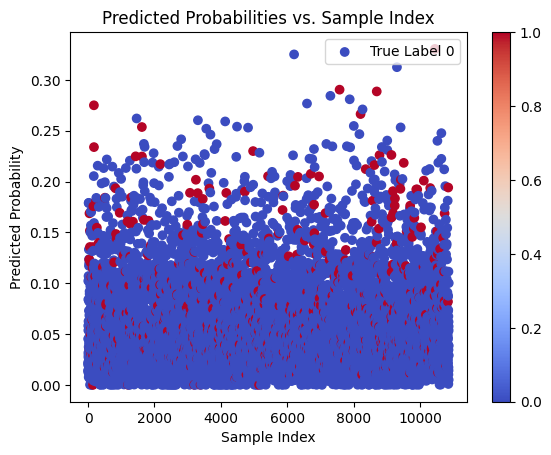

In [193]:
# plot the probabilities of the model and color each point by the true label, and add legend to the plot:
plt.scatter(range(len(test_eval_results['probabilities'])), test_eval_results['probabilities'], c=test_eval_results['lables'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs. Sample Index')
plt.legend(['True Label 0', 'True Label 1'], loc='upper right')
plt.show()


maybe add class weight and use BCEWithLogitLoss, need to add pos_weight argument. 